In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
import pyvista as pv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import logging
import pint
from scipy.constants import mu_0 as _mu_0
from scipy.special import iv, jv # Modified Bessel function of the first kind

Q = pint.UnitRegistry()
Q.setup_matplotlib()



logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
pv.set_jupyter_backend('static') 

In [3]:
_mu_0

1.25663706212e-06

In [4]:
RESOLUTION=100


In [5]:
vtu_files = [f  for f in os.listdir(os.path.join(os.curdir,'results')) if f.endswith('.vtu')]
vtu_files.sort()
print(f'{len(vtu_files)} vtu files found')

360 vtu files found


In [47]:
diameter = 4e-3 * Q.meter
conductivity = 37e6 * Q.siemens / Q.meter
resistivity = 1 / conductivity
frequency = 2500 * Q.Hz

resistance = 1 / (conductivity * np.pi * diameter**2 / 4)
resistance.to(Q.ohm/Q.meter)

omega = (frequency * 2 * np.pi).to(Q.rad/Q.second)
stepsPerPeriod = len(vtu_files)
periods = 1
nsteps = periods*stepsPerPeriod

MU_0 = _mu_0 * Q.henry / Q.meter
mu_r = 1
mu = mu_r * MU_0

dt = (1/(nsteps * frequency)).to(Q.second)
dt


<Quantity(1.11111111e-06, 'second')>

In [48]:
tidx= 90
mesh_t0 = pv.read(os.path.join(os.curdir,'results', vtu_files[tidx]))
mesh_t0['magnetic flux density mag'] = np.linalg.norm(mesh_t0['magnetic flux density e'], axis=1)


In [49]:
min_x, max_x, min_y, max_y, min_z, max_z = mesh_t0.GetBounds()

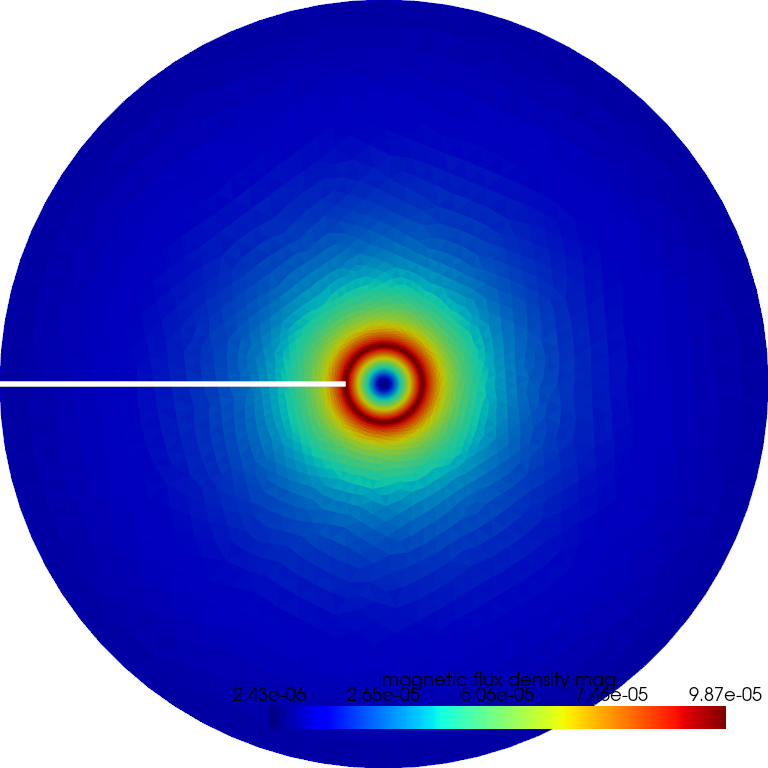

In [50]:
p = pv.Plotter(notebook=True)
# calculate the magnetic flux density magnitude
p.add_mesh(mesh_t0, scalars='magnetic flux density mag', show_edges=False, cmap='jet')
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.add_mesh(pv.Line((min_x,0, 0), (-diameter.to_base_units().m/2, 0, 0)), color='white', line_width=5)
p.show()

line_sample = mesh_t0.sample_over_line((min_x,0, 0), (-diameter.to_base_units().m/2, 0, 0), resolution=RESOLUTION)


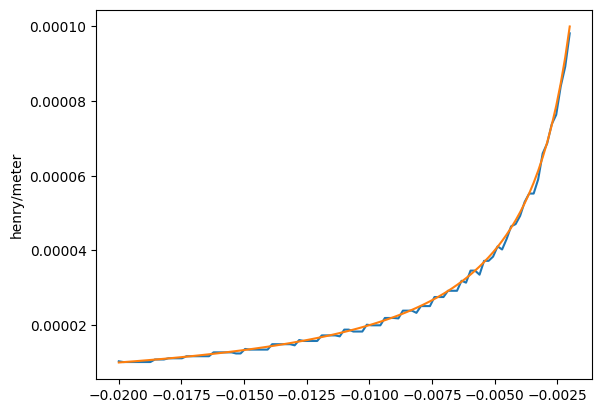

In [51]:
b_mag = np.abs(MU_0 * np.sin(dt * omega * tidx) / (2 * np.pi * line_sample.points[:,0]) )
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(line_sample.points[:,0], line_sample['magnetic flux density mag'])
ax.plot(line_sample.points[:,0], b_mag)
t_idx = 0

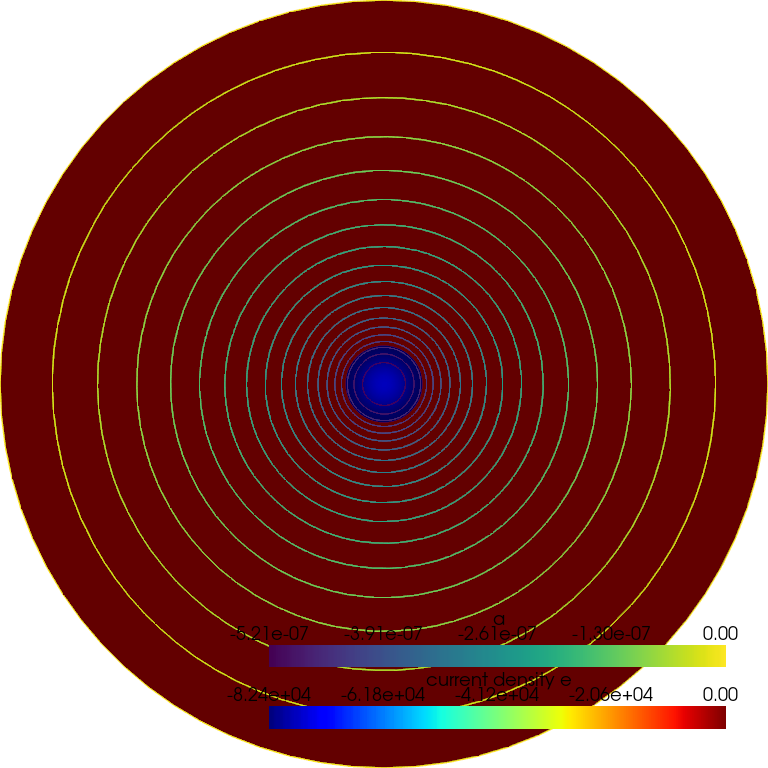

In [52]:
p = pv.Plotter(notebook=True)
p.add_mesh(mesh_t0, scalars="current density e", component=2, show_edges=False, cmap='jet')
p.add_mesh(mesh_t0.contour(isosurfaces=20, scalars='a', method='contour'), point_size=2, show_edges=False, opacity=1, scalars="a")
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()

In [53]:
WIRE_1_ID = 1
WIRE_2_ID = 2

wire_1 = mesh_t0.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")

In [54]:
diameter.to_base_units().m

0.004

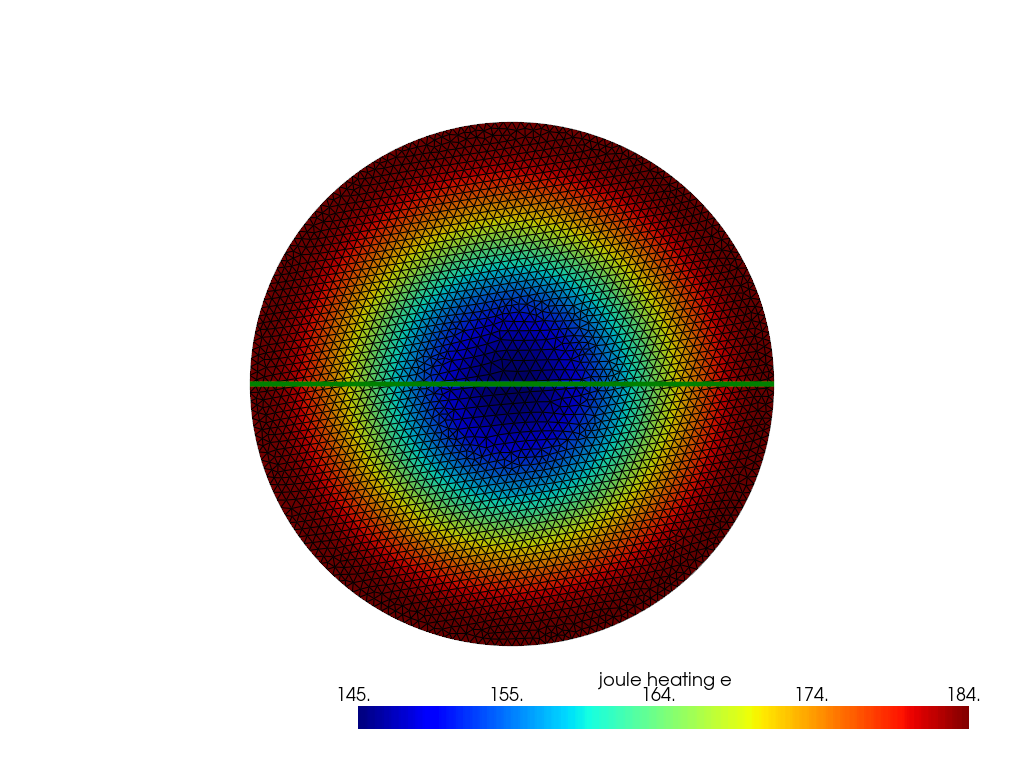

In [55]:
p = pv.Plotter(shape=(1, 1))
p.subplot(0, 0)
p.add_mesh(wire_1, scalars="joule heating e", component=2, show_edges=True, cmap='jet')
#p.update_scalar_bar_range([-200e3, 0])
p.set_viewup([0, 1, 0])
p.add_mesh(pv.Line((-diameter.to_base_units().m/2, 0, 0), (diameter.to_base_units().m/2, 0, 0)), color='green', line_width=5)

# p.subplot(0, 1)

# p.add_mesh(wire_1, scalars="joule heating e", show_edges=True, cmap='jet')
# p.set_viewup([0,1,0])
p.show()

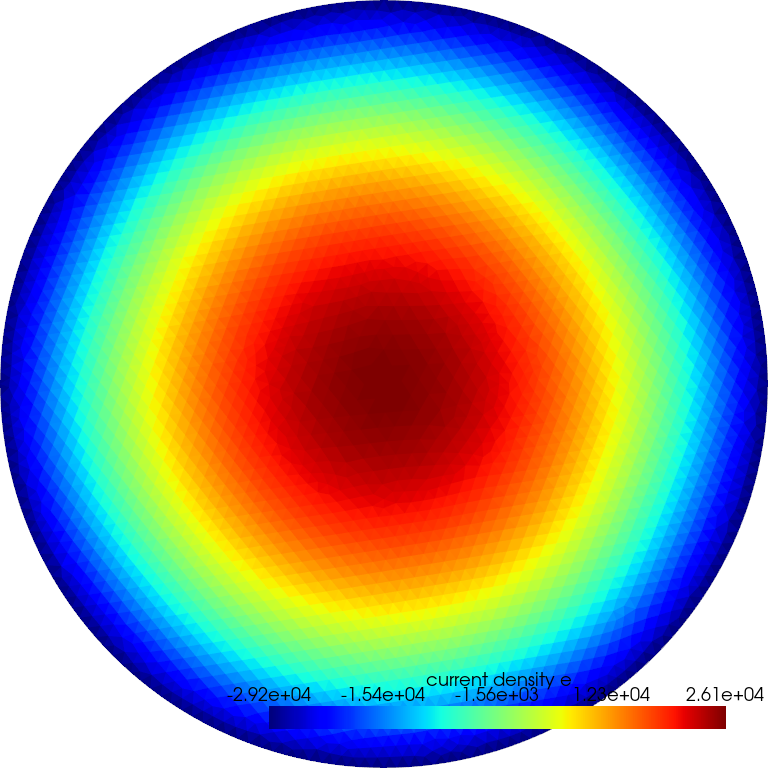

/home/mjfwest/repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:322: RuntimeWarning: invalid value encountered in multiply
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/home/mjfwest/repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
/home/mjfwest/repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4796: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the scalars of a mesh in-place instead.
  warnings.warn(


In [56]:


p = pv.Plotter(notebook=True, off_screen=True)
p.open_gif('results/j.gif')

mesh = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))
wire_mesh = mesh.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")
p.add_mesh(wire_mesh, scalars="current density e", component=2, show_edges=False, cmap='jet', lighting=False)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()
p.update_scalar_bar_range([-7e6, 7e6])

wire_currrent = np.empty((len(vtu_files), 2)) * Q.A
wire_joule_heating = np.empty((len(vtu_files), 2)) * Q.W / Q.m
wire_current_density = np.empty((len(vtu_files), RESOLUTION+1)) * Q.A / Q.m**2
wire_positions = np.linspace(-diameter/2, diameter/2, RESOLUTION+1)

for idx, vtu_file in enumerate(vtu_files):
    mesh = pv.read(os.path.join(os.curdir,'results', vtu_file))
    for wire in [WIRE_1_ID, WIRE_2_ID]:
        wire_mesh = mesh.threshold([wire - 0.1, wire + 0.1], scalars="GeometryIds")
        wire_mesh_int = wire_mesh.integrate_data()
        wire_currrent[idx, wire - 1] = wire_mesh_int['current density e'][0, 2] * Q.A # 2 is the z component
        wire_joule_heating[idx, wire - 1] = wire_mesh_int['joule heating e'][0] * Q.W / Q.m
        # sample across the wire,
        if wire == WIRE_1_ID:
            p.update_coordinates(wire_mesh.points, render=False)
            p.update_scalars(wire_mesh['current density e'][:,2], render=False)
            p.write_frame()
            line_sample = wire_mesh.sample_over_line((-diameter.to_base_units().m / 2, 0, 0),
                                                     ( diameter.to_base_units().m / 2, 0, 0), resolution=RESOLUTION)
            wire_current_density[idx] = line_sample['current density e'][:,2] * Q.A / Q.m**2
p.close()

In [57]:
delta = np.sqrt((2 * resistivity)/((2*np.pi*frequency).to(Q.rad/Q.s) * mu))
delta.to(Q.mm)

<Quantity(1.6548143, 'millimeter')>

In [58]:
mu / (4e-7 *np.pi)

<Quantity(1.0, 'henry / meter')>

In [62]:
 
def J(r, i, diameter, resistivity, frequency, mu):
    omega = (frequency * 2 * np.pi).to(Q.rad/Q.s)
    print(omega )
    delta = np.sqrt((2 * resistivity)/(omega * mu))
    delta.ito(Q.m)
    diameter.ito(Q.m)
    i.ito(Q.A)
    r.ito(Q.m)
    k = (1 - 1j) / delta.m
    j_r = ((k * i.m)/(2 * np.pi * (diameter/2).m)) * (jv(0, (k*r).m) / jv(1, (k*(diameter/2)).m))
    return j_r

15707.963267948966 radian / second


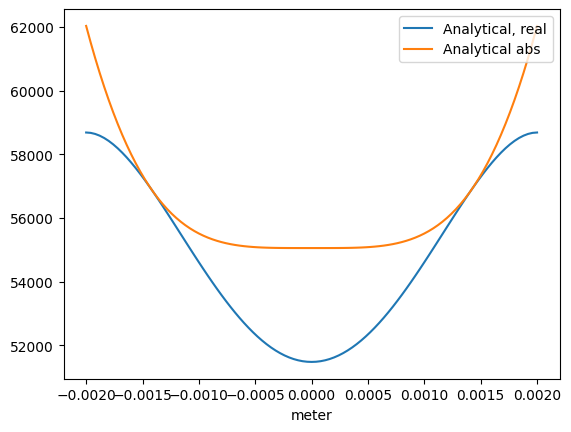

In [63]:
j = J(wire_positions, 1/np.sqrt(2) * Q.A, diameter, resistivity, frequency, mu)

plt.plot(wire_positions, j.real, label='Analytical, real')
#plt.plot(wire_positions, j.imag, label='Analytical, imag')
plt.plot(wire_positions, np.abs(j), label='Analytical abs')
plt.legend( loc='upper right')

In [64]:
1/np.sqrt(2) * Q.A / (np.pi * (diameter/2)**2).to(Q.m**2)

<Quantity(56269.7698, 'ampere / meter ** 2')>

In [65]:
r = (1 + 1j) * diameter.to(Q.m) / delta
f_skin = 0.5 * (r.to_base_units().magnitude * iv(0, r.to_base_units().magnitude) / iv(1, r.to_base_units().magnitude)).real

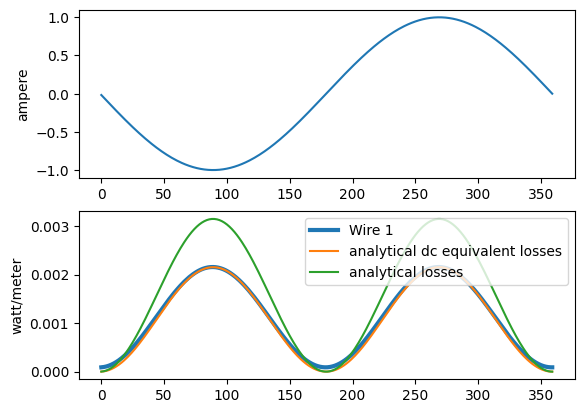

In [66]:

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(wire_currrent[:,0], label='Wire 1')

ax2 = fig.add_subplot(212)
ax2.plot(wire_joule_heating[:,0], label='Wire 1', linewidth=3)
ax2.plot(wire_currrent[:,0]**2 * resistance , label='analytical dc equivalent losses')
ax2.plot(wire_currrent[:,0]**2 * resistance * f_skin, label='analytical losses')
ax2.legend()

In [67]:
f_skin

np.float64(1.4623532894161169)

In [68]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[0.0 61742.82512003145 61335.60825231392 60666.86767265918 60214.5523000363 59899.397963534604 59257.1837621962 58931.206349363914 58675.117415956614 58380.27744446113 57886.00004179183 57886.00004179183 57406.71585237675 57190.61840114709 57018.548701319196 56827.173340822475 56507.78010369249 56376.40906129101 56228.87039987795 56115.36902880514 55987.18162595517 55762.059117652585 55762.059117652585 55586.72277330361 55503.380895110065 55438.80828660151 55368.67533001721 55256.51836310441 55212.672642730686 55164.43053480407 55083.69899128767 55083.69899128767 55023.52081805745 55000.32877087689 54977.81867967177 54977.81867967177 54934.38702622729 54918.841704912076 54907.339905341985 54896.48570860597 54888.15414847272 54881.31051772484 54881.31051772484 54872.800265664046 54872.800265664046 54870.32757600497 54868.56551240957 54868.56551240957 54867.255415904765 54867.255415904765 54867.255415904765 54868.69094697579 54868.69094697579 54871.22356438567 54871.22356438567 54876.43856658576 54876.43856658576 54881.04291119545 54885.66896013326 54892.85325706986 54900.22391184584 54910.339913791446 54921.9372045549 54934.06285005121 54949.12094636187 54988.27105607893 54988.27105607893 55012.59912965911 55052.17162005222 55103.85267733879 55137.43319910213 55170.41786140285 55216.77407944057 55315.12786604678 55315.12786604678 55434.39473113519 55591.296100792526 55591.296100792526 55762.11473204201 55868.16629193057 55962.65838113998 56085.772190686854 56338.113946943464 56338.113946943464 56628.6332226158 56837.45275311202 56992.85990703178 57372.99436535695 57601.53969437164 57802.06984113168 58057.862975061114 58283.56684800725 58568.20442436838 59135.48953595219 59191.17141651794 59820.85926238832 60512.47608439966 60512.47608439966 61291.05264816488 61748.78773523211 0.0]
Units,ampere/meter2


In [69]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[0.0 61742.82512003145 61335.60825231392 60666.86767265918 60214.5523000363 59899.397963534604 59257.1837621962 58931.206349363914 58675.117415956614 58380.27744446113 57886.00004179183 57886.00004179183 57406.71585237675 57190.61840114709 57018.548701319196 56827.173340822475 56507.78010369249 56376.40906129101 56228.87039987795 56115.36902880514 55987.18162595517 55762.059117652585 55762.059117652585 55586.72277330361 55503.380895110065 55438.80828660151 55368.67533001721 55256.51836310441 55212.672642730686 55164.43053480407 55083.69899128767 55083.69899128767 55023.52081805745 55000.32877087689 54977.81867967177 54977.81867967177 54934.38702622729 54918.841704912076 54907.339905341985 54896.48570860597 54888.15414847272 54881.31051772484 54881.31051772484 54872.800265664046 54872.800265664046 54870.32757600497 54868.56551240957 54868.56551240957 54867.255415904765 54867.255415904765 54867.255415904765 54868.69094697579 54868.69094697579 54871.22356438567 54871.22356438567 54876.43856658576 54876.43856658576 54881.04291119545 54885.66896013326 54892.85325706986 54900.22391184584 54910.339913791446 54921.9372045549 54934.06285005121 54949.12094636187 54988.27105607893 54988.27105607893 55012.59912965911 55052.17162005222 55103.85267733879 55137.43319910213 55170.41786140285 55216.77407944057 55315.12786604678 55315.12786604678 55434.39473113519 55591.296100792526 55591.296100792526 55762.11473204201 55868.16629193057 55962.65838113998 56085.772190686854 56338.113946943464 56338.113946943464 56628.6332226158 56837.45275311202 56992.85990703178 57372.99436535695 57601.53969437164 57802.06984113168 58057.862975061114 58283.56684800725 58568.20442436838 59135.48953595219 59191.17141651794 59820.85926238832 60512.47608439966 60512.47608439966 61291.05264816488 61748.78773523211 0.0]
Units,ampere/meter2


(54503.598287849265, 62096.979677782576)

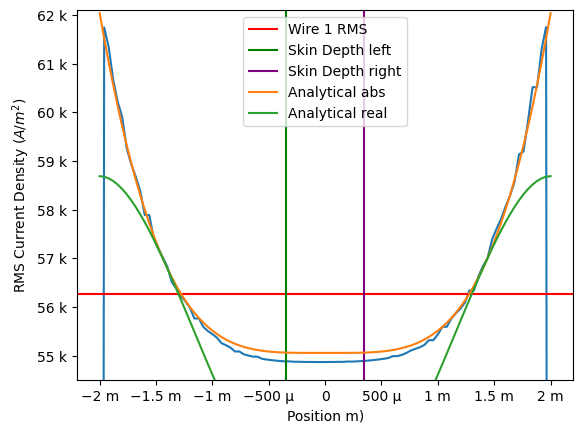

In [70]:

fig = plt.figure()
ax = fig.add_subplot(111)
#use the enginering tick formatter

ax.yaxis.set_major_formatter(EngFormatter())
ax.xaxis.set_major_formatter(EngFormatter())
ax.plot(wire_positions, np.sqrt(np.mean(wire_current_density**2, axis=0)))
ax.set_xlabel('Position m)')
ax.set_ylabel('RMS Current Density ($A/m^2$)')

rms_dc_current_density = np.sqrt(np.mean(wire_currrent**2, axis=0)) / (np.pi * (diameter/2)**2)

ax.axhline(rms_dc_current_density[0], color='red', label='Wire 1 RMS')
ax.axvline(-diameter/2+delta, color='green', label='Skin Depth left')
ax.axvline(diameter/2-delta, color='purple', label='Skin Depth right')
ax.plot(wire_positions, np.abs(j), label='Analytical abs')
ax.plot(wire_positions, j.real, label='Analytical real')
#ax.plot(wire_positions, j.imag, label='Analytical imag')
ax.legend()
ax.set_ylim( min(np.abs(j))  * 0.99, max(np.abs(j)) * 1.001)